# OpenEO demonstration
Here, we demonstrate the OpenEO capabilities. First, we show its basics, setting up connections, etc. 
In other Notebooks, you can explore how to extract data cubes from the different Terrascope collections.<br>
First, we import the required packages and set up a default OpenEO connection.

In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

Below, the ```show_tiff``` function is defined.

In [38]:
DEFAULT_FIGSIZE = (5, 4)

def show_tiff(filename:str, figsize=DEFAULT_FIGSIZE, vmin=None, vmax=None, rescale_percentile=97, add_colorbar=False):
    """Small helper to load a geotiff and visualize it"""
    with rasterio.open(filename) as ds:
        data = ds.read()

    fig, ax = plt.subplots(figsize=figsize)

    if len(data.shape) == 3:
        if data.max() > 500:
            p = np.percentile(data, rescale_percentile, axis=[1,2])
            data = data / p[:, None, None]
            data = np.clip(data, 0, 1)
        data = np.moveaxis(data, 0, 2)
        data = data[:,:,0]
        
    im = ax.imshow(data, vmin=vmin, vmax=vmax)
    if add_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.05)

Check the OpenEO version, should be 0.6.x.

In [39]:
openeo.client_version()

'0.6.0'

In [40]:
con = openeo.connect("https://openeo.vito.be")
con

<Connection to 'https://openeo.vito.be/openeo/1.0/' with NullAuth>

A default connection has been set up, but of course we want to authenticate more securely. This is offered using the EGI authentication option, see the [Terrascope OpenEO documentation](https://docs.terrascope.be/#/Developers/WebServices/OpenEO/OpenEO) for more details on the set-up procedure.

In [47]:
con.authenticate_oidc(provider_id="egi")

To authenticate: visit https://aai.egi.eu/oidc/device and enter the user code '1ZRYzV'.
Authorized successfully.
Authenticated using device code flow.


<Connection to 'https://openeo.vito.be/openeo/1.0/' with BearerAuth>

The connection has been securely made, now let's check the account information.

In [42]:
con.describe_account()["info"]

'Erwin Wolters'

That looks good! Let us proceed now with some data stuff from Sentinel-2. First, we define a bounding box, the Sentinel-2 band selection, and the time period. The more we can constrain area and time period, the more limited the amount of data becomes.

In [52]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
bands = ["B04", "B03", "B02"]
dates = ("2021-03-06", "2021-03-07")

We select from the Sentinel-2 TOC reflectance (Level-2A) data product and filter on the provided spatial and temporal constraints.

In [53]:
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=bands)
cube = cube.filter_bbox(bbox=bbox)
cube = cube.filter_temporal(dates)

What we have constructed is a DataCube object, which is a symbolic representation of the operations we want to perform.

In [49]:
cube

We can download data from this DataCube object as e.g. a GeoTiff file. Note that this may take some time, depending on the file size, but this example is only ~1 MB.

In [54]:
cube.download("basic.tiff", format="GTIFF")

Show the image.

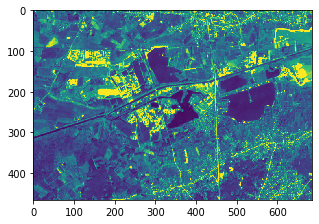

In [55]:
show_tiff("basic.tiff")

## Band math: NDVI
To illustrate the "band math" feature of the openEO Python Client Library we calculate the NDVI, a popular vegetation state indicator, which is computed from the Sentinel-2 Red and near-infrared (NIR):

$$ \mathrm{NDVI} = \frac{\mathrm{NIR} - \mathrm{Red}}{\mathrm{NIR} + \mathrm{Red}} $$

We redefine the dates and bands to be selected from the TOC reflectance data product. Then, we load the cube from the collection, extract the Red and NIR TOC reflectances, and compute and download the NDVI.

In [17]:
dates = ("2021-03-06", "2021-03-07")
bands = ["B04", "B08"]

# Note that we can specify bounding box and temporal extent directly in the `load_collection` process
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", spatial_extent=bbox, temporal_extent=dates, bands=bands)

#extract the Red and NIR from the data cube
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

#...and download the image
ndvi.download("ndvi.tiff", format="GTIFF")

(1, 466, 686)


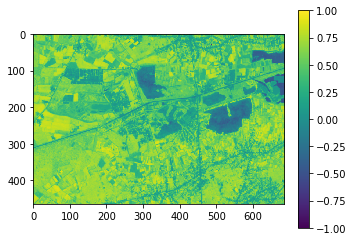

In [31]:
show_tiff("ndvi.tiff", vmin=-1, vmax=1, add_colorbar=True)

## Cloud masking
The example above shows the NDVI on a day with clear skies. As this is certainly not always the case, we need to mask out pixels that were labelled as clouds by the Sentinel-2 cloud screening.<br>
First, let's have a look a more cloudy day.

In [32]:
dates = ("2020-07-21", "2020-07-22")

bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
bands = ["B04", "B03", "B02"]

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", spatial_extent=bbox, temporal_extent=dates, bands=bands)
cube.download("basic-clouded.tiff", format="GTIFF")

(3, 466, 686)


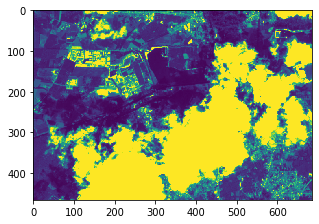

In [35]:
show_tiff("basic-clouded.tiff", rescale_percentile=70)

It is evident that this image contains quite some clouds, as can be seen from the highly reflecting areas.<br>
So we need to remove these from the image. We can do this using the associated Scene Classification file.

In [56]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
dates = ("2020-07-21", "2020-07-22")
bands = ["B04", "B08", "SCL"]
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", temporal_extent=dates, spatial_extent=bbox, bands=bands)

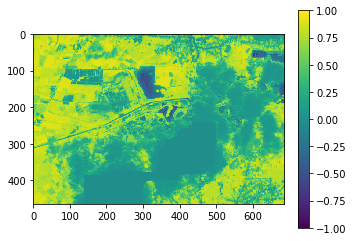

In [57]:
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)
ndvi.download("ndvi-clouded.tiff", format="GTiff")
show_tiff("ndvi-clouded.tiff", vmin=-1, vmax=1, add_colorbar=True)

You can see that cloud-contaminated pixels have much lower NDVI values (typically < 0). We will apply the scene classification to filter out these pixels.<br>
We are only interested in the classifications 'vegeration' and 'bare soil' and will remove all other classes.

In [60]:
classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5)) #only select pixels for which the Scene Classification has value 4 (vegetation) or 5 (bare soil).

DataCube(<ReduceNode 'reduce_dimension' at 0x7fb73cc558d0>)


In [61]:
mask.download("mask-orig.tiff", format="GTiff")

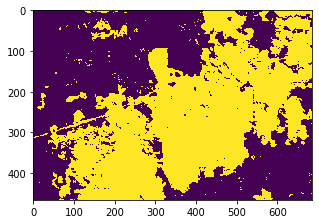

In [62]:
show_tiff("mask-orig.tiff")

The dark parts in this image are pixels classified as class 4 or 5, and the other (light) pixels are the pixels we want to discard (replace with NaN = not a value).
Note that this mask image is a but noisy. We can expand the light area to be a bit more conservative on the useable pixels. <br>
Such "dilation" can be implemented by applying a Gaussian blur and threshold operation.

First, create a simple gaussian kernel:

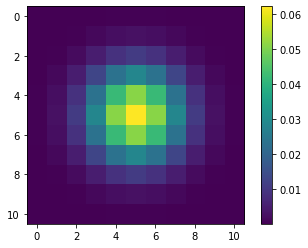

In [63]:
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()
im = plt.imshow(kernel)
plt.colorbar(im)

Convolve the mask image with the kernel and apply a threshold. Then, download the mask GeoTiff file and show the results.

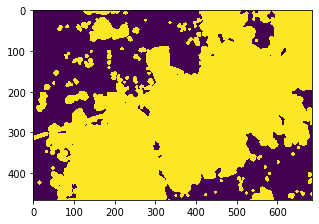

In [65]:
mask = mask.apply_kernel(kernel)
mask = mask > 0.1
mask.download("mask.tiff", format="GTiff")
show_tiff("mask.tiff")

Great, we have a smoother mask now.
Let's apply this mask to the NDVI data. The masked pixels will get a NaN value.

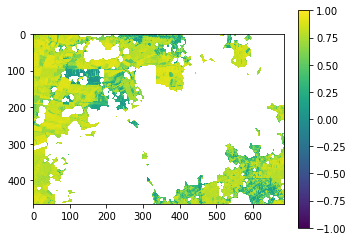

In [67]:
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)
masked_ndvi.download("ndvi-masked.tiff", format="GTIFF")
show_tiff("ndvi-masked.tiff", vmin=-1, vmax=1, add_colorbar=True)

And there we have an NDVI image with clouds masked out! NaN values are show as white, so that looks as desired.